<a href="https://colab.research.google.com/github/Berusov/Event_predict/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D1%83%D1%81%D0%BF%D0%B5%D1%88%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BC%D0%B5%D1%80%D0%BE%D0%BF%D1%80%D0%B8%D1%8F%D1%82%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Загрузка данных
url = "https://raw.githubusercontent.com/Berusov/Event_predict/main/events_hall_dataset_with_scores.csv"
data = pd.read_csv(url)


# Признаки и целевая переменная
features = ["duration", "audience_size", "award_duration", "num_items", "perf_duration", "host_speech_duration"]
target = "success_score"

X = data[features]
y = data[target]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвейер с масштабированием и моделью
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Добавление полиномиальных признаков
    ('model', GradientBoostingRegressor(random_state=42))  # Применение Gradient Boosting
])

# Кросс-валидация с 5 фолдами для оценки модели
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"Средняя абсолютная ошибка (MAE) на кросс-валидации: {-cv_scores.mean():.2f}")

# Оптимизация гиперпараметров с помощью GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Средняя абсолютная ошибка модели: {mae:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

# Функция для предсказания успешности нового мероприятия
def predict_success(event_features):
    event_df = pd.DataFrame([event_features], columns=features)
    predicted_score = best_model.predict(event_df)[0]
    return predicted_score



Средняя абсолютная ошибка (MAE) на кросс-валидации: 0.35
Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Средняя абсолютная ошибка модели: 0.20
Коэффициент детерминации (R²): 0.97


In [ ]:
# Пример предсказания
test_event = {
    "duration": 120,  # Продолжительность мероприятия (мин)
    "audience_size": 1331,  # Размер аудитории (чел)
    "award_duration": 45,  # Длительность награждения (мин)
    "num_items": 29,  # Количество номеров/активностей
    "perf_duration": 73,  # Длительность выступлений (мин)
    "host_speech_duration": 2  # Длительность речи ведущих (мин)
}

test_score = predict_success(test_event)
print(f"Прогнозируемая успешность мероприятия: {test_score:.2f}")

Прогнозируемая успешность мероприятия: 9.55


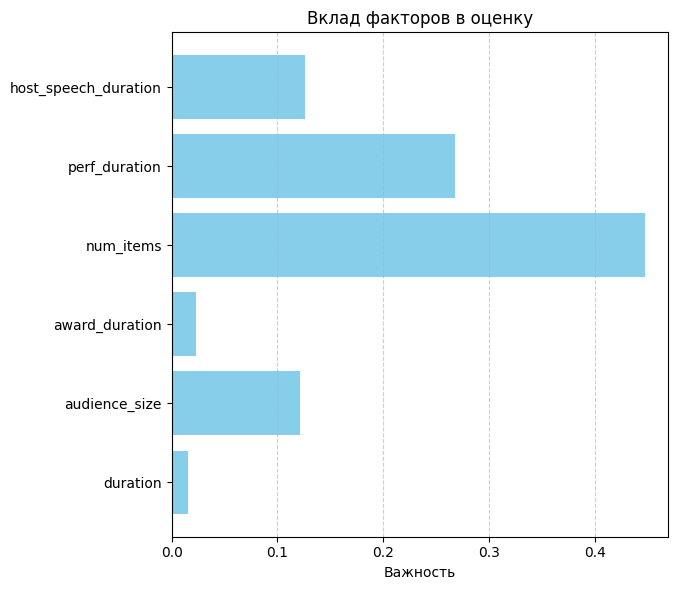

In [ ]:
    # Функция для визуализации
    def update_plot(duration, audience_size, award_duration, num_items, perf_duration, host_speech_duration):
        test_event = {
            'duration': duration,
            'audience_size': audience_size,
            'award_duration': award_duration,
            'num_items': num_items,
            'perf_duration': perf_duration,
            'host_speech_duration': host_speech_duration
        }

        score = predict_success(list(test_event.values()))

        # Получаем важность признаков (только для исходных признаков)
        gbr = best_model.named_steps['model']
        poly = best_model.named_steps['poly']

        # Получаем имена полиномиальных признаков
        try:
            poly_feature_names = poly.get_feature_names_out(features)
        except AttributeError:
            poly_feature_names = features

        # Берем важность только исходных признаков (первые n)
        if len(gbr.feature_importances_) > len(features):
            feature_importances = gbr.feature_importances_[:len(features)]
        else:
            feature_importances = gbr.feature_importances_

        # Нормализуем важность признаков
        feature_importances = feature_importances / feature_importances.sum()

        # Визуализация
        plt.figure(figsize=(12, 6))

        # График важности признаков
        plt.subplot(1, 2, 1)
        plt.barh(features, feature_importances, color='skyblue')
        plt.title('Вклад факторов в оценку')
        plt.xlabel('Важность')
        plt.grid(axis='x', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

    # Создаем выпадающие списки с возможностью ручного ввода
    def create_dropdown(options, value, description):
        return widgets.Dropdown(
            options=options,
            value=value,
            description=description,
            style={'description_width': 'initial'},
            continuous_update=False,
            ensure_option=True  # Это предотвратит ошибку при несовпадении значения
        )

    duration_options = list(range(0, 241))
    duration_dropdown = create_dropdown(
        options=duration_options,
        value=120,
        description='Длительность (мин):'
    )

    audience_options = list(range(0, 1332))
    audience_dropdown = create_dropdown(
        options=audience_options,
        value=800,
        description='Аудитория:'
    )

    award_options = list(range(0, 601))
    award_dropdown = create_dropdown(
        options=award_options,
        value=20,
        description='Награждения (мин):'
    )

    num_items_options = list(range(0, 101))
    num_items_dropdown = create_dropdown(
        options=num_items_options,
        value=12,
        description='Кол-во номеров:'
    )

    perf_options = list(range(0, 601))
    perf_dropdown = create_dropdown(
        options=perf_options,
        value=60,
        description='Выступления (мин):'
    )

    host_options = list(range(0, 601))
    host_dropdown = create_dropdown(
        options=host_options,
        value=15,
        description='Речь ведущих (мин):'
    )

    # Создаем кнопку для обновления графика
    update_button = widgets.Button(
        description='Рассчитать оценку',
        button_style='success',
        tooltip='Нажмите для расчета'
    )

    # Контейнер для всех элементов управления
    controls = widgets.VBox([
        duration_dropdown,
        audience_dropdown,
        award_dropdown,
        num_items_dropdown,
        perf_dropdown,
        host_dropdown,
        update_button
    ])

    # Функция для обработки нажатия кнопки
    def on_button_clicked(b):
        update_plot(
            duration_dropdown.value,
            audience_dropdown.value,
            award_dropdown.value,
            num_items_dropdown.value,
            perf_dropdown.value,
            host_dropdown.value
        )

    update_button.on_click(on_button_clicked)

    # Отображаем элементы управления
    display(controls)

    # Первоначальный расчет с дефолтными значениями
    update_plot(
        duration_dropdown.value,
        audience_dropdown.value,
        award_dropdown.value,
        num_items_dropdown.value,
        perf_dropdown.value,
        host_dropdown.value
    )
